<font size="5"> Capstone Project: 2018 Stackoverflow Developer Survey analysis<br> 

<font size="4">Table of Contents <br> 
<br> <font size="2.5">
[1 DataWrangling](#DataWrangling)<br> 
<br>
[2 Data Preprocessing](#DataPreprocessing) <br> 
<br>
[3 Data Exploration/ Statistical Analysis](#DataExploration) <br> 
[3.1 Correlation between variables](#Correlation) <br>
[3.2 T-test between populations](#T-test) <br>
[3.3 Data by Country/Continent](#DatabyCountry/Continent) <br>
<br>
[4 Data Visualization](#DataViz) <br> 
[4.1 Variables affecting Career Satisfaction](#Carsatvsother) <br> 
<br>
[5 Machine Learning (In progress)](#MachineLearning)


In [1]:
#https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey
%matplotlib inline
%autosave 30
#%%time
import numpy as np
import researchpy as rp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_selection 
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore")#, category=SettingWithCopyWarning)

Autosaving every 30 seconds


In [2]:
############################## FUNCTIONS TO NUMERICIZE VARIABLES #################################
def seriesify(df,strd,numd,colname):
    ziptemp = zip(strd,numd)
    dictemp = dict(ziptemp)
    return df[colname].replace(dictemp)
def dummify(df,colname,ser):
    ser = ser.rename(colname+'_n')
    df = pd.concat([df,ser],axis=1)
    df = df.drop(colname,axis=1)
    return df

<a id='DataWrangling'></a> <font size="5"><b>Data Wrangling</b>

In [3]:
%%time
survey_questions = pd.read_csv('survey_results_schema.csv')
data = pd.read_excel('survey_results_public_filtered.xlsx')

Wall time: 26.2 s


In [4]:
data.shape

(98855, 20)

In [5]:
pd.DataFrame(data.isnull().sum().sort_values(ascending=False)) # Num of null values in each column

,0
ConvertedSalary,51153
SelfTaughtTypes,41501
EducationTypes,30895
JobSatisfaction,29579
EthicalImplications,29546
AIFuture,29127
EthicsReport,28429
EthicsChoice,28073
CompanySize,27324
HoursOutside,26831


<div class="span5 alert alert-success">
22,000 missing CareerSatisfaction responses and 51,153 missing ConvertedSalary responses are some of the biggest features with missing variables.    
</div> 

In [6]:
## Drop NaN values from certain columns
clean_df = data.dropna(subset=['EthicalImplications','AIFuture','YearsCoding','EthicsReport','EthicsChoice',\
                              'CompanySize','HoursOutside','Exercise','CareerSatisfaction','DevType'])

In [7]:
clean_df.shape

(48943, 20)

In [8]:
# Num of null values in each column where salary is not Null
pd.DataFrame(data[data.ConvertedSalary.isnull()==False].isnull().sum().sort_values(ascending=False)).head(10);

In [9]:
df_dropped_majors = data.dropna(subset=['UndergradMajor'])
ugrad_majors = pd.DataFrame(df_dropped_majors['UndergradMajor'].value_counts(normalize=True)*100).round(1)
ugrad_majors.columns=['Percentage'];ugrad_majors

,Percentage
"Computer science, computer engineering, or software engineering",63.7
"Another engineering discipline (ex. civil, electrical, mechanical)",8.8
"Information systems, information technology, or system administration",8.2
"A natural science (ex. biology, chemistry, physics)",3.9
Mathematics or statistics,3.6
Web development or web design,3.1
"A business discipline (ex. accounting, finance, marketing)",2.4
"A humanities discipline (ex. literature, history, philosophy)",2.0
"A social science (ex. anthropology, psychology, political science)",1.7
"Fine arts or performing arts (ex. graphic design, music, studio art)",1.4


<div class="span5 alert alert-success">
A lot of people from non-CS related backgrounds tend to switch to programming as a career. About 36% of developers didn't major in CS as undergraduates. With the rise of programming bootcamps, it is getting easier to switch to programming regardless of your background. Health science majors are least likely to switch to programming whereas STEM majors were much more likely to do the same. </div> 

In [10]:
clean_df.shape

(48943, 20)

In [11]:
clean_df.head();

In [12]:
countries = clean_df['Country'].value_counts();top_countries = countries[0:10] #top 10 countries with most respondents; 
top_20_countries = countries[0:20];last_20_countries=countries[-20:];countries_100_resp = countries[0:55]

<font size="5"><a id='DataPreprocessing'></a> <b>Data Preprocessing</b>

In [13]:
df = clean_df.copy()
dfd = clean_df.copy() #dataframe for dissatisfaction
dflr = clean_df.copy() #dataframe for logreg
dflrd = clean_df.copy() #dataframe for logreg dissatisfaction

In [14]:
clean_df.CareerSatisfaction.unique()

array(['Extremely satisfied', 'Neither satisfied nor dissatisfied',
       'Slightly dissatisfied', 'Moderately satisfied',
       'Slightly satisfied', 'Moderately dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [15]:
#Replace AIFuture values with shorter terms
clean_df['AIFuture'].replace(["I'm excited about the possibilities more than worried about the dangers.","I'm worried about the dangers more than I'm excited about the possibilities.",       "I don't care about it, or I haven't thought about it."],['Excited','Worried','DontCare'],inplace=True) 

In [16]:
#NUMERICIZE VARIABLES
#Replace employed full time/part time with FT/PT
df['Employment'].replace(['Employed full-time','Employed part-time'],['FT','PT'],inplace=True) 
#Numericize CareerSatisfaction
if 'CareerSatisfaction' in df.columns:
    cs_str=df['CareerSatisfaction'].unique()
    cs_num = [3,0,-1,2,1,-2,-3] 
    cs_ser = seriesify(df,cs_str,cs_num,'CareerSatisfaction')
    df=dummify(df,'CareerSatisfaction',cs_ser)
#Numericize CompanySize
if 'CompanySize' in df.columns:
    comp_str=df['CompanySize'].unique()
    comp_num = [10000,15,300,1250,60,750,7500,5]
    comp_ser = seriesify(df,comp_str,comp_num,'CompanySize')
    df=dummify(df,'CompanySize',comp_ser)
#Convert Years of Coding to numeric variable
if 'YearsCoding' in df.columns:
    years = df['YearsCoding'].unique()
    yrs_num =[30,7,10,16,13,4,1,19,25,22,28]
    yrs_cod_ser = seriesify(df,years,yrs_num,'YearsCoding')
    df=dummify(df,'YearsCoding',yrs_cod_ser)
#Numericize HoursOutside
if 'HoursOutside' in df.columns:
    hrsout_str = df['HoursOutside'].unique()
    hrsout_num = [.75,1.5,.25,3.5,4.5]
    hrsout_ser = seriesify(df,hrsout_str,hrsout_num,'HoursOutside')
    df=dummify(df,'HoursOutside',hrsout_ser)
#Numericize Exercise
if 'Exercise' in df.columns:
    ex_str=df['Exercise'].unique()
    ex_num = [6,3.5,1.5,0]
    ex_ser = seriesify(df,ex_str,ex_num,'Exercise')
    df=dummify(df,'Exercise',ex_ser)
#Numericize AIFuture
if 'AIFuture' in df.columns:
    aifuturestr=df['AIFuture'].unique()
    aifuturenum = [1,-1,0]
    ai_ser = seriesify(df,aifuturestr,aifuturenum,'AIFuture')
    df=dummify(df,'AIFuture',ai_ser)
#Numericize waketime
if 'WakeTime' in df.columns:
    wtstr=df['WakeTime'].unique()
    wtnum = [530,630,430,730,930,0,830,1030,1130,1230,0,-1]
    wt_ser = seriesify(df,wtstr,wtnum,'WakeTime')
    df=dummify(df,'WakeTime',wt_ser)

In [17]:
#DUMMIFY VARIABLES
#Dummify Hobby columns
if 'Hobby' in df.columns:
    df = pd.get_dummies(data=df, columns=['Hobby'])
    df = df.drop('Hobby_No',axis=1)
#Dummify OpenSource
if 'OpenSource' in df.columns:
    df = pd.get_dummies(data=df, columns=['OpenSource'])
    df = df.drop('OpenSource_No',axis=1)
#Dummify EthicalImplications
if 'EthicalImplications' in df.columns:
    ethimpstr=df['EthicalImplications'].unique()
    ethimpnum=[3,2,1]
    ethimp_ser = seriesify(df,ethimpstr,ethimpnum,'EthicalImplications')
    df=dummify(df,'EthicalImplications',ethimp_ser)
#Dummify EthicsReport
if 'EthicsReport' in df.columns:
    ethrepstr=df['EthicsReport'].unique()
    ethrepnum=[0,1,2,-1]
    ethrep_ser = seriesify(df,ethrepstr,ethrepnum,'EthicsReport')
    df=dummify(df,'EthicsReport',ethrep_ser)

In [18]:
#Dummify DevType
mlb = MultiLabelBinarizer()
dev_types = clean_df['DevType'].unique()
devtypelist = df['DevType'].str.split(';')
devtypelist.rename('NewDevType',inplace=True)
df_dev_type = pd.concat([df,devtypelist],axis=1)
df_dev_type = df_dev_type.drop('DevType',axis=1)
dev_type_num=pd.DataFrame(mlb.fit_transform(df_dev_type['NewDevType']),columns=mlb.classes_, index=df_dev_type.index)#.head()
if 'DevType' in df.columns:   #concatenate DevType dummified to df
    df = df.drop('DevType',axis=1)
    df = pd.concat([df,dev_type_num],axis=1)

In [19]:
df.iloc[:,9:120].head(1);

In [20]:
df_no_dev = pd.concat([df.iloc[:,9:19]],axis=1) #feature variable DF without devtype and career satisfaction 
df_no_dev.head(2);

In [21]:
df.iloc[:,8:19]; #Feature variables
df_car_sat_y = df.iloc[:,8] #target var career sat

In [22]:
df_total = pd.concat([df_no_dev,df_car_sat_y],axis=1)#Data frame to test ML 

In [23]:
df_total.head();

In [24]:
#Add continents to the DF
continents =pd.read_csv('Countries-Continents.csv')
continents['Country'].replace(['Burma (Myanmar)','Iran','Venezuela',
                               'Congo, Democratic Republic of','Congo','Ivory Coast','US','Vietnam','Korea, South','Macedonia',
                              'Tanzania','Syria','Moldova'],
                              ['Myanmar','Iran, Islamic Republic of...','Venezuela, Bolivarian Republic of...',
                               'Democratic Republic of the Congo','Congo, Republic of the...',"CÃ´te d'Ivoire",'United States',
                               'Viet Nam','South Korea','The former Yugoslav Republic of Macedonia',
                              'United Republic of Tanzania','Syrian Arab Republic','Republic of Moldova'],inplace=True) 
added = pd.DataFrame({'Continent':['Asia','Asia','Asia','Europe'],'Country':['Hong Kong (S.A.R.)','Taiwan','Republic of Korea','Czech Republic']})
continents = continents.append(added,ignore_index = True);

In [25]:
%%time
african = continents[continents.Continent =='Africa']#.loc[:,'Country']
asian = continents[continents.Continent =='Asia']
NAmerican = continents[continents.Continent =='North America']
SAmerican = continents[continents.Continent =='South America']
oceania = continents[continents.Continent =='Oceania']
european = continents[continents.Continent =='Europe']
countries=(pd.DataFrame(countries))
def get_continent(d):
    continent = []
    for row in d:
        if row in asian.Country.unique():
            continent.append('Asia') 
        elif row in NAmerican.Country.unique():
            continent.append('North America') 
        elif row in (SAmerican.Country).unique():
            continent.append('Sount America') 
        elif row in (oceania.Country.unique()):
            continent.append('Oceania') 
        elif row in (european.Country.unique()):
            continent.append('Europe') 
        elif row in (african.Country.unique()):  
            continent.append('Africa')
        else:
            continent.append('Other')
    return continent

continent = get_continent(df['Country'])
df['Continent'] = continent

Wall time: 27.3 s


<a id='DataExploration'></a> <font size="5"><b>Data Exploration/Statistical Analysis</b>

<a id='Correlation'></a> <font size="4"><b>Correlation</b>

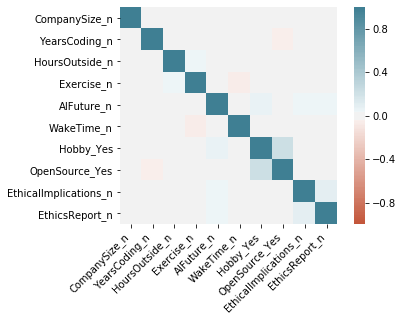

In [26]:
#df.iloc[:,9:19].corr(method='pearson')
corr = df.iloc[:,9:19].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [27]:
df.iloc[:,8:19].corr()

,CareerSatisfaction_n,CompanySize_n,YearsCoding_n,HoursOutside_n,Exercise_n,AIFuture_n,WakeTime_n,Hobby_Yes,OpenSource_Yes,EthicalImplications_n,EthicsReport_n
CareerSatisfaction_n,1.000000,-0.016657,-0.000273,-0.014543,0.022787,0.048146,-0.006721,0.048823,0.061609,0.055937,0.035417
CompanySize_n,-0.016657,1.000000,0.026201,0.014505,-0.011839,-0.011968,0.033755,0.009607,0.025492,-0.025880,-0.016952
YearsCoding_n,-0.000273,0.026201,1.000000,0.024941,0.002318,0.018079,0.020485,-0.002014,-0.039559,-0.038202,0.002775
HoursOutside_n,-0.014543,0.014505,0.024941,1.000000,0.040306,-0.008483,-0.021993,0.007255,0.025180,-0.034360,-0.026416
Exercise_n,0.022787,-0.011839,0.002318,0.040306,1.000000,0.009595,-0.048047,-0.008045,-0.006122,0.013695,-0.009417
AIFuture_n,0.048146,-0.011968,0.018079,-0.008483,0.009595,1.000000,0.015511,0.064187,0.011790,0.042229,0.045369
WakeTime_n,-0.006721,0.033755,0.020485,-0.021993,-0.048047,0.015511,1.000000,-0.009489,0.009694,-0.032390,-0.009406
Hobby_Yes,0.048823,0.009607,-0.002014,0.007255,-0.008045,0.064187,-0.009489,1.000000,0.219958,0.024029,-0.006088
OpenSource_Yes,0.061609,0.025492,-0.039559,0.025180,-0.006122,0.011790,0.009694,0.219958,1.000000,0.031500,-0.030134
EthicalImplications_n,0.055937,-0.025880,-0.038202,-0.034360,0.013695,0.042229,-0.032390,0.024029,0.031500,1.000000,0.098079


<div class="span5 alert alert-success">
None of the variables seem to be correlated strongly. The only 2 variables which are at least slightly correlated (0.26) are "Open source" and "Hobby". This makes sense because people who program as a hobby are also more likely to contribute to open source projects as a part of that hobby.
 </div> 

<a id='T-test'></a> <font size="4"><b>T-test</b> <br>
<font size="3">T-test to see if populations who filled out all of the survey vs who left some fields blank are different. 

In [28]:
df_empty_cs = data[(data.ConvertedSalary.isnull()) & (data.CareerSatisfaction.isnull()==False)]; #dataframe with empty salary
df_not_empty_cs =  data[(data.ConvertedSalary.isnull() == False) & (data.CareerSatisfaction.isnull()==False)];#dataframe with filled salary

In [29]:
df_not_empty_cs.shape

(46965, 20)

In [30]:
df_empty_cs.shape;

In [31]:
df_not_empty_cs.shape;

In [32]:
data.dropna().shape;

In [33]:
data_ttest = data.copy()
data_ttest.dropna(subset=['CareerSatisfaction'],inplace=True)
data_ttest.CareerSatisfaction.unique()

array(['Extremely satisfied', 'Neither satisfied nor dissatisfied',
       'Moderately satisfied', 'Slightly dissatisfied',
       'Slightly satisfied', 'Moderately dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [34]:
if 'CareerSatisfaction' in df_empty_cs.columns:
    cs_str=df_empty_cs['CareerSatisfaction'].unique()
    cs_num = [3,2,-1,-2,-3,0,1]
    cs_ser = seriesify(df_empty_cs,cs_str,cs_num,'CareerSatisfaction')
    df_empty_cs=dummify(df_empty_cs,'CareerSatisfaction',cs_ser)
if 'CareerSatisfaction' in df_not_empty_cs.columns:
    cs_str=df_not_empty_cs['CareerSatisfaction'].unique()
    cs_num = [0,2,1,-2,-1,3,-3] 
    cs_ser = seriesify(df_not_empty_cs,cs_str,cs_num,'CareerSatisfaction')
    df_not_empty_cs=dummify(df_not_empty_cs,'CareerSatisfaction',cs_ser)
if 'CareerSatisfaction' in data_ttest.columns:
    cs_str=data_ttest['CareerSatisfaction'].unique()
    cs_num = [3,0,2,-1,1,-2,-3] 
    cs_ser = seriesify(data_ttest,cs_str,cs_num,'CareerSatisfaction')
    data_ttest=dummify(data_ttest,'CareerSatisfaction',cs_ser)

Career Sat. on a scale from -3 to 3.

In [35]:
print('Mean Career Sat. of people with empty Salary: {:0.2f} '.format(df_empty_cs.CareerSatisfaction_n.mean())) 

Mean Career Sat. of people with empty Salary: 1.00 


In [36]:
print('Mean Career Sat. of people with filled Salary: {:0.2f} '.format(df_not_empty_cs.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with filled Salary: 1.23 


In [37]:
print('Mean Career Sat. of people with multiple empty responses: {:0.2f} '.format(df.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with multiple empty responses: 1.24 


In [38]:
print('Mean Career Sat. of people with all filled responses: {:0.2f} '.format(data_ttest.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with all filled responses: 1.14 


In [39]:
np.std(df_empty_cs.CareerSatisfaction_n)

1.6814715696253375

In [40]:
np.std(df_not_empty_cs.CareerSatisfaction_n)

1.6051041035377622

In [41]:
np.std(data_ttest.CareerSatisfaction_n)

1.6388906979881948

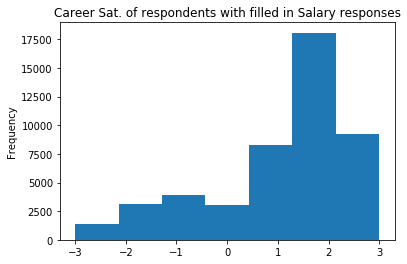

In [42]:
df_not_empty_cs.CareerSatisfaction_n.plot(kind='hist',bins=7);
plt.title('Career Sat. of respondents with filled in Salary responses');

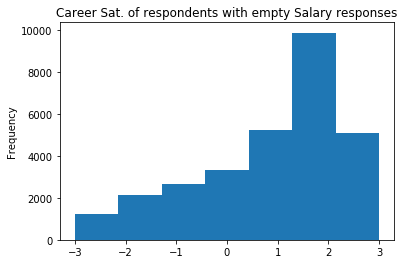

In [43]:
df_empty_cs.CareerSatisfaction_n.plot(kind='hist',bins=7);
plt.title('Career Sat. of respondents with empty Salary responses');

In [44]:
print('Stats for population with filled vs empty salary response: ')
print(stats.ttest_ind(df_empty_cs.CareerSatisfaction_n, df_not_empty_cs.CareerSatisfaction_n))

Stats for population with filled vs empty salary response: 
Ttest_indResult(statistic=-19.060104640254124, pvalue=8.345891344835878e-81)


In [45]:
print('Stats for population with everything filled vs multiple unfilled responses: ')
print(stats.ttest_ind(df.CareerSatisfaction_n, data_ttest.CareerSatisfaction_n)) 

Stats for population with everything filled vs multiple unfilled responses: 
Ttest_indResult(statistic=10.054379685199006, pvalue=8.971604673330457e-24)


<div class="span5 alert alert-success">
Using the T-Test, we can say that among the populations, ones who didn't reply to the salary or other questions and the ones who did, are different. The ones who answer more questions tend to be more satisfied with their career on average. 

<a id='DatabyCountry/Continent'></a> <font size="3"><b>Data by Country/Continent</b> <br>
<font size="2">

In [139]:
data.shape

(98855, 20)

In [143]:
#Number of respondents from each country
counts = clean_df.Country.value_counts().reset_index(name='NumResponses')
continent_c= get_continent(counts.iloc[:,0]);
counts['Continent'] = continent_c
print('Total responses from 10 most respresented countries: '+ str(counts.iloc[:10,1:2].sum()[0]))

Total responses from 10 most respresented countries: 32423


<div class="span5 alert alert-success">
    Two thirds of the responses come from the 10 most represented countries

In [144]:
pd.DataFrame(counts.groupby('Continent')['NumResponses'].sum()).style.set_caption("Number of responses by Continent")

,NumResponses
Continent,
Africa,926
Asia,10497
Europe,18995
North America,15063
Oceania,1481
Other,36
Sount America,1945


In [150]:
counts.columns = ['Country', 'NumResponses', 'Continent'];
counts.index = range(1,len(counts)+1);
counts.head(10);counts.head(10).style.set_caption("10 most represented countries")

,Country,NumResponses,Continent
1,United States,12626,North America
2,India,4932,Asia
3,United Kingdom,3588,Europe
4,Germany,3507,Europe
5,Canada,1862,North America
6,France,1312,Europe
7,Russian Federation,1279,Asia
8,Australia,1170,Oceania
9,Brazil,1169,Sount America
10,Netherlands,978,Europe


Index(['index', 'NumResponses', 'Continent'], dtype='object')

In [48]:
#Num countries with at least 100 respondents
print('Number of countries with at least 100 responses: '+str(counts[counts.NumResponses>=100].shape[0]))

Number of countries with at least 100 responses: 57


In [49]:
counts_perc = pd.DataFrame(counts.groupby('Continent').count()['NumResponses']);counts_perc['%']= counts_perc['NumResponses']*100/counts_perc['NumResponses'].sum()
counts_perc;counts_perc.style.set_caption("% of countries by continent")

,NumResponses,%
Continent,,
Africa,33,21.4286
Asia,43,27.9221
Europe,44,28.5714
North America,18,11.6883
Oceania,3,1.94805
Other,2,1.2987
Sount America,11,7.14286


In [50]:
count100 = counts[(counts.NumResponses>=100)]
count100_perc = pd.DataFrame(count100.groupby('Continent').count()['NumResponses'])
count100_perc['%']= count100_perc['NumResponses']*100/count100_perc['NumResponses'].sum()
count100_perc
count100_perc.style.set_caption("% of countries (with at least 100 respondents) by continent")

,NumResponses,%
Continent,,
Africa,3,5.26316
Asia,17,29.8246
Europe,28,49.1228
North America,3,5.26316
Oceania,2,3.50877
Sount America,4,7.01754


<div class="span5 alert alert-success">
After comparing the 2 tables above, we can see that Asian, African and poorer North American countries are underrespresented in the data.

In [51]:
salaries_median = clean_df.groupby('Country')['ConvertedSalary'].median() #Median salary by country. # for specific: [clean_df['Country'].isin(last_20_countries.index)]
salaries_mean = pd.DataFrame(clean_df.groupby('Country')['ConvertedSalary'].mean()) #Mean of salaries by country
salaries_diff = salaries_median - salaries_mean;salaries_mean = pd.DataFrame(salaries_mean)
salaries_median = pd.DataFrame(salaries_median.sort_values(ascending=False))
salaries_median.head(10)
salaries_median.head(10).style.set_caption("Countries with highest salary")

,ConvertedSalary
Country,
Liechtenstein,426042
Botswana,140000
Sierra Leone,120000
United States,100000
Switzerland,93842
Israel,91284
Bahamas,88500
Norway,82890
Denmark,82452


<div class="span5 alert alert-success">
Checking the countries with the highest salary, we can see that there are definitely a few countries with poor or non-existing data.

In [52]:
#Median salary in countries with at lease 100  respondents
pd.DataFrame(clean_df[clean_df['Country'].isin(top_countries.index)].groupby('Country')['ConvertedSalary'].median().sort_values(ascending=False))

,ConvertedSalary
Country,
United States,100000.0
Australia,79973.0
Canada,64417.0
United Kingdom,62507.0
Germany,62412.0
Netherlands,55075.0
France,48955.0
Russian Federation,21228.0
Brazil,19350.0


<div class="span5 alert alert-success">
After removing countries with less than 100 datapoints, we find cleaner data. Not surprisingly, western countries have a much higher median income than developing countries. Developers in the US make 9X as much as those in India (where many IT jobs are outsourced). 

In [53]:
clean_df.shape

(48943, 20)

In [54]:
df_total_w_countries = pd.concat([df.Country,df_total],axis=1)

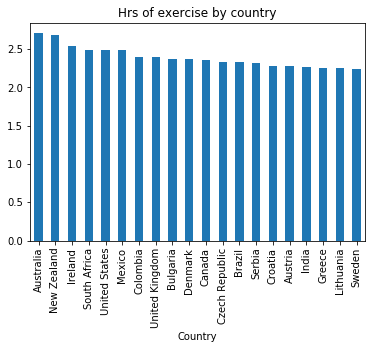

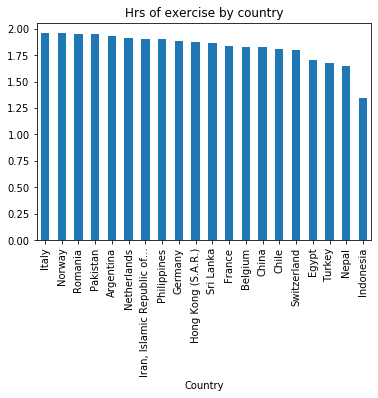

In [55]:
#??? how to plot
exercisedf = pd.DataFrame(df_total_w_countries[df_total_w_countries.Country.isin(countries_100_resp.index)].groupby('Country')['Exercise_n'].mean().sort_values(ascending=False))
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) 
#??? how to plit up horizontally
fig = exercisedf.head(20).plot(kind='bar');fig.get_legend().remove();plt.title('Hrs of exercise by country');
fig = exercisedf.tail(20).plot(kind='bar');fig.get_legend().remove();plt.title('Hrs of exercise by country');

<div class="span5 alert alert-success">Mean hours of exercise by country.

<a id='DataViz'></a> <font size="5"><b>Data Visualization</b>

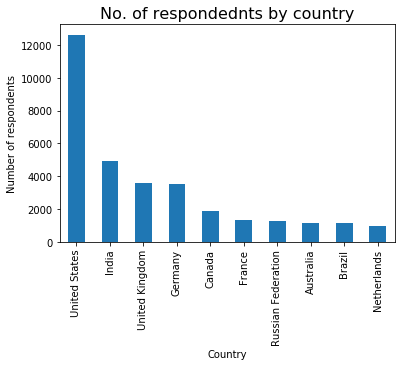

In [56]:
clean_df[clean_df['Country'].isin(top_countries.index)]['Country'].value_counts().plot(kind='bar');
_=plt.ylabel('Number of respondents')
_=plt.xlabel('Country')
_=plt.title('No. of respondednts by country',fontsize=16);

<div class="span5 alert alert-success">
Most of the respondents are from the US and many of the rest are from other western countries so we'd expect this dataset to heavily represent people living in Western democracies.

<a id='Carsatvsother'></a> <font size="4"><b>Variables affecting Career Satisfaction </b>

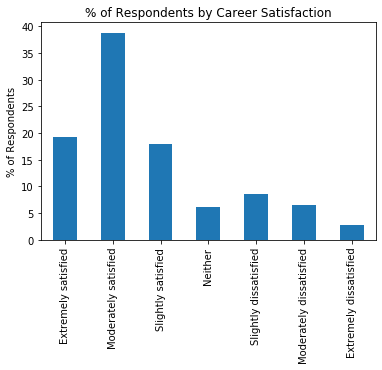

In [57]:
df_car_sat = pd.DataFrame(clean_df['CareerSatisfaction'].value_counts())
df_car_sat['% of Respondents'] = df_car_sat['CareerSatisfaction']*100/df_car_sat['CareerSatisfaction'].sum()
career_sat_order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']#replace by car sat list
career_sat_order_short = [ 'Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']#replace by car sat list
dict_car_sat = {'Extremely satisfied':'Extremely satisfied','Moderately satisfied':'Moderately satisfied','Slightly satisfied':'Slightly satisfied','Neither satisfied nor dissatisfied':'Neither','Slightly dissatisfied':'Slightly dissatisfied', 'Moderately dissatisfied':'Moderately dissatisfied','Extremely dissatisfied':'Extremely dissatisfied'}
df_car_sat = df_car_sat.reindex(career_sat_order)
df_car_sat.rename(index=dict_car_sat,inplace=True)
df_car_sat_perc = df_car_sat[['% of Respondents']]
fig = df_car_sat_perc.plot(kind='bar');
plt.ylabel('% of Respondents');
fig.get_legend().remove()
plt.title('% of Respondents by Career Satisfaction');

<div class="span5 alert alert-success">
About 40% of the people surveyed were moderatly satisfied, and on a whole, about 75% of the people were satisfied to some extent with their jobs. About 17% were dissatisfied and the rest were neither. 

In [58]:
df_c = clean_df[clean_df['Country'].isin(top_20_countries.index)];
df_c =df_c.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0);

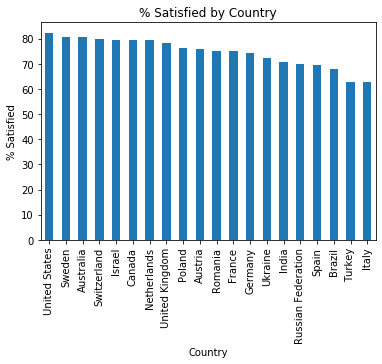

In [59]:
def satisfaction_perc(df_c):
    df_c['Total'] = df_c[['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
    df_c['Satisfied']=df_c[['Extremely satisfied','Moderately satisfied','Slightly satisfied']].sum(axis=1)
    df_c['% Satisfied'] =  df_c['Satisfied']*100/df_c['Total']  
    df_c['% Ext. Satisfied'] =  df_c['Extremely satisfied']*100/df_c['Total']  
    df_c['% Mod. Satisfied'] =  df_c['Moderately satisfied']*100/df_c['Total'] 
    df_c['% Sl. Satisfied'] =  df_c['Slightly satisfied']*100/df_c['Total'] 
    df_c['% Dissatisfied'] = 100-df_c['% Satisfied']-(df_c['Neither satisfied nor dissatisfied']*100/df_c['Total'])
    return df_c

df_c = satisfaction_perc(df_c)
df_c['Country1']=df_c.index
fig =df_c[['Country1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove()
plt.ylabel('% Satisfied');
plt.title('% Satisfied by Country');

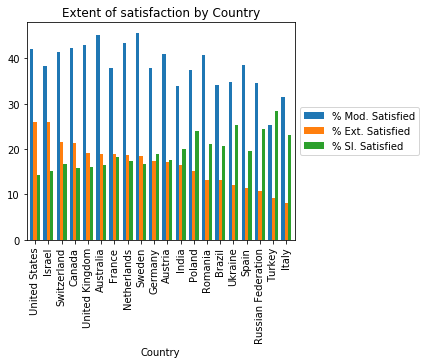

In [60]:
df_c_sorted =df_c.sort_values('% Satisfied',ascending=False) ;
fig = df_c_sorted[['% Mod. Satisfied','% Ext. Satisfied', '% Sl. Satisfied']].sort_values('% Ext. Satisfied',ascending=False).plot(kind='bar',width=.75) ;
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Extent of satisfaction by Country');

<div class="span5 alert alert-success">
Developers from non-western countries like Russia, Brazil and India are more likely to be sliglty satisfied whereas developers in western countries tend to be moderately or extremely satisfied by their jobs. We see an inverse relationship with Slight satisfaction and extreme satisfaction with the job. 

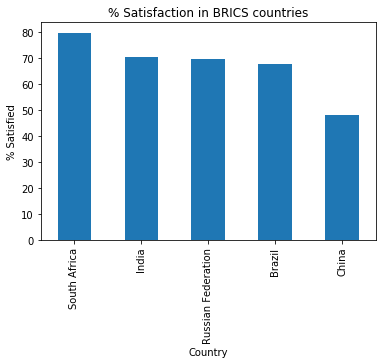

In [61]:
#Plotting satisfaction in BRICS countries
df_brics = clean_df[clean_df['Country'].isin(['Brazil','Russian Federation','India','China','South Africa'])]
df_brics['Country'].unique()
df_brics =df_brics.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0)
df_brics['Total'] = df_brics[['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
df_brics['Satisfied']=df_brics[['Extremely satisfied','Moderately satisfied','Slightly satisfied']].sum(axis=1)
df_brics['% Satisfied'] =  df_brics['Satisfied']*100/df_brics['Total']  
df_brics['Country1']=df_brics.index
fig =df_brics[['Country1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove()
plt.ylabel('% Satisfied');
plt.title('% Satisfaction in BRICS countries');

<div class="span5 alert alert-success">
China has a much lower career satisfaction compared to other BRICS countries.

In [62]:
df_c_100 = clean_df[clean_df['Country'].isin(countries_100_resp.index)];#***
df_c_100 =df_c_100.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0);
df_c_100 = satisfaction_perc(df_c_100)
pd.DataFrame(df_c_100.iloc[:,9].sort_values(ascending=False)).head(10)

,% Satisfied
Country,
Denmark,83.522727
United States,82.361793
Serbia,81.645570
Sweden,80.835735
Australia,80.769231
South Africa,79.840849
Switzerland,79.663866
Israel,79.476861
Canada,79.377014


In [63]:
pd.DataFrame(df_c_100.iloc[:,9].sort_values(ascending=False)).tail(10)

,% Satisfied
Country,
Spain,69.616205
Nepal,69.523810
Brazil,67.835757
Turkey,62.735849
Italy,62.690707
Indonesia,61.971831
Japan,61.081081
Malaysia,59.627329
Hong Kong (S.A.R.),59.459459


<a id='Carsatvsother'></a> <font size="4"><b>Undergrad Major </b>

In [64]:
df_um = clean_df[clean_df['Country'].isin(top_20_countries.index)];
df_um = df_um.groupby(['UndergradMajor', 'CareerSatisfaction'])['UndergradMajor'].count().unstack('CareerSatisfaction').fillna(0);
df_um = satisfaction_perc(df_um)

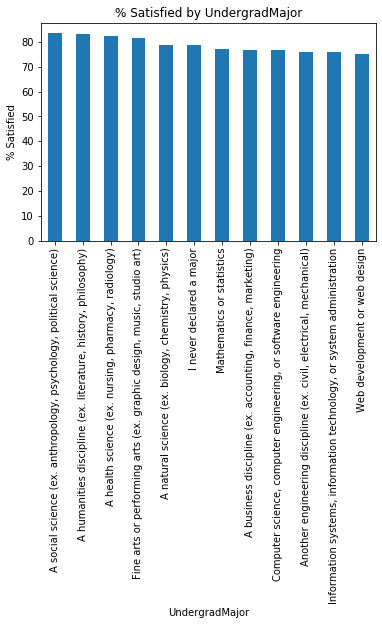

In [65]:
df_um = satisfaction_perc(df_um)
df_um['UndergradMajor1']=df_um.index
fig =df_um[['UndergradMajor1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove()
plt.ylabel('% Satisfied');
plt.title('% Satisfied by UndergradMajor');

<div class="span5 alert alert-success">
Developers who did not major in CS or another STEM degree are happier than developers who majored in CS or STEM fields. And people who make a bigger switch (i.e. from sociology to CS vs Math to CS) are happier.  

<font size="3"><b>Hobby </b>

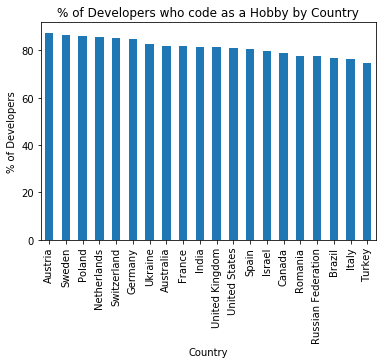

In [66]:
df1 = clean_df[clean_df['Country'].isin(top_20_countries.index)] 
df2 =df1.groupby(['Country', 'Hobby'])['Country'].count().unstack('Hobby').fillna(0)
df2['Total']=df2['No']+df2['Yes']
df2['% Yes'] = df2['Yes']*100/df2['Total']
df2['% No']=100-df2['% Yes']
df3 = df2.sort_values(by='Total',ascending=False)
fig=df3[['% Yes']].sort_values('% Yes',ascending=False).plot(kind='bar', stacked=True) 
plt.title('% of Developers who code as a Hobby by Country'); 
plt.ylabel('% of Developers')
fig.get_legend().remove()

<div class="span5 alert alert-success">
Developers from european countries are more likely to program as a hobby. It's also interesting to see that the more people code as a hobby, the more likely they are to be satisfied with their career (comparing with plot above). Russia, India and Brazil lag behind many of their western counterparts in job satisfaction.

<font size="3"><b>Years of Coding Experience</b>

In [67]:
usdata = data[data.Country == 'United States'].dropna(subset=['DevType','ConvertedSalary','YearsCoding']);
usdatacopy = usdata.copy()

In [68]:
#Convert Years of Coding in USA to numeric variable
if 'YearsCoding' in usdata.columns:
    years = usdata['YearsCoding'].unique()
    yrs_num =[10,30,19,4,7,13,16,1,22,25,28]
    yrs_cod_ser = seriesify(usdata,years,yrs_num,'YearsCoding')
    usdata=dummify(usdata,'YearsCoding',yrs_cod_ser)

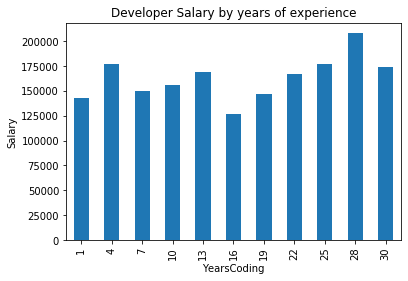

In [69]:
#clean_df_dev[clean_df_dev.DevType.isin(dev_types_single)].groupby(['DevType']).count();
df_dev =  clean_df.copy() 
df_dev.dropna(subset=['ConvertedSalary'],inplace=True)
if 'YearsCoding' in df_dev.columns:
    years = df_dev['YearsCoding'].unique()
    yrs_num =[30,7,10,16,13,4,1,19,25,22,28]
    yrs_cod_ser = seriesify(df_dev,years,yrs_num,'YearsCoding')
    df_dev=dummify(df_dev,'YearsCoding',yrs_cod_ser)
df_dev[df_dev.Country == 'United States'].groupby(['YearsCoding_n'])['ConvertedSalary'].mean().plot(kind='bar');
plt.ylabel('Salary');plt.xlabel('YearsCoding');plt.title('Developer Salary by years of experience');

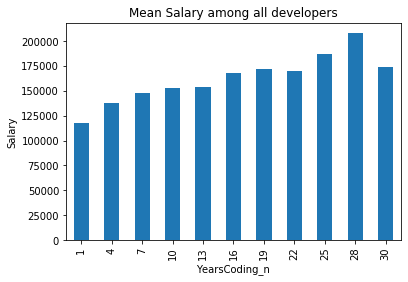

In [70]:
usdata_plt =usdata.groupby(['YearsCoding_n'])['ConvertedSalary'].mean().sort_index().plot(kind='bar');plt.title('Mean Salary among all developers');plt.ylabel('Salary');
#['Hobby'].count().unstack('YearsCoding').fillna(0)
#Convert Years of Coding to numeric variable
#usdata.groupby(['YearsCoding_n'])['ConvertedSalary'].mean()#.sort_values()

<div class="span5 alert alert-success">
More experience generally (but not always) mean a higher salary. Developer type aso plays a role in determining the salary.

In [71]:
dev_types_single = ['Full-stack developer','Back-end developer','Mobile developer','Front-end developer','Data scientist or machine learning specialist','Desktop or enterprise applications developer','Embedded applications or devices developer']

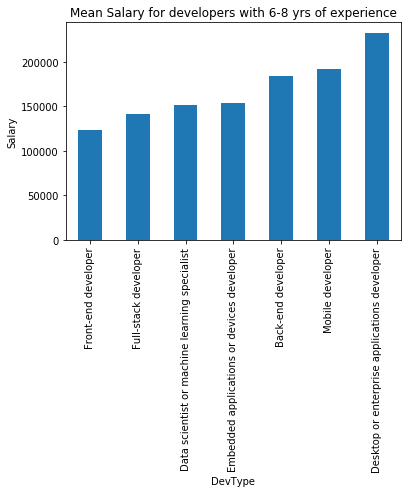

In [72]:
#Controlling for years coding, plot salaries by developer type.
usdata[usdata.DevType.isin(dev_types_single) & (usdata.YearsCoding_n == 7)].groupby(['DevType'])['ConvertedSalary'].mean().sort_values().plot(kind='bar');plt.title('Mean Salary for developers with 6-8 yrs of experience');plt.ylabel('Salary');

<div class="span5 alert alert-success">
Desktop or enterprise applications developer are the highest paid (among mid career people with 6-8 years of experience). 

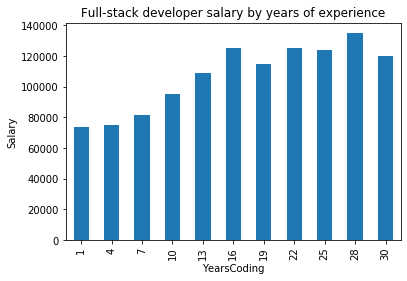

In [73]:
usdata_singledt = usdata[usdata.DevType.isin(dev_types_single)]
usdata_singledt.dropna(subset=['ConvertedSalary'],inplace=True)
usdata_singledt[usdata_singledt.DevType=='Full-stack developer'].groupby(['YearsCoding_n'])['ConvertedSalary'].median().plot(kind='bar');
plt.ylabel('Salary');plt.xlabel('YearsCoding');plt.title('Full-stack developer salary by years of experience');

<div class="span5 alert alert-success">
Years of coding (when controlling for country and developer type does matter when it comes to income. The rise in salary is higher in the beginning. 

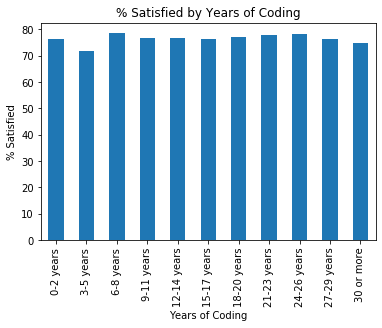

In [74]:
df_yc = pd.concat([df.iloc[:,0:19],clean_df],axis=1)
df_yc = df_yc.groupby(['YearsCoding_n', 'CareerSatisfaction'])['YearsCoding_n'].count().unstack('CareerSatisfaction').fillna(0);
df_yc = satisfaction_perc(df_yc);fig =df_yc[['% Satisfied']].plot(kind='bar');fig.get_legend().remove();
fig.set_xticklabels(['0-2 years','3-5 years','6-8 years','9-11 years','12-14 years','15-17 years', '18-20 years'
                     , '21-23 years',  '24-26 years' , '27-29 years','30 or more']);plt.ylabel('% Satisfied');plt.xlabel('Years of Coding');plt.title('% Satisfied by Years of Coding');

<div class="span5 alert alert-success">
Years of coding doesn't seem to have a clear effect on career satisfaction. The only major change that can be seen is a drop in satisfaction after the initial 0-2 years, and then again after 3-5 years. One explanation could be that developers are initially excited with their new careers/jobs and hence the high career satisfaction.

<font size="3"><b>Company Size</b>

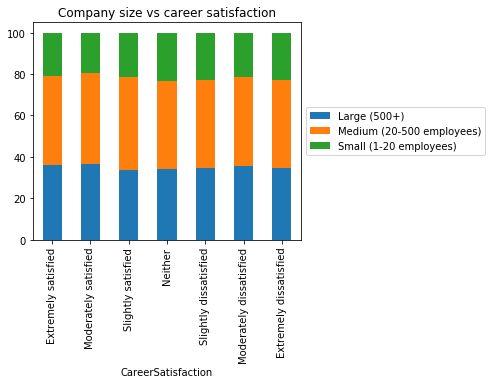

In [75]:
df_comp =clean_df.groupby(['CompanySize','CareerSatisfaction'])['CompanySize'].count().unstack('CareerSatisfaction').fillna(0)
order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
xtixks_car_sat = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
df_comp=df_comp[order]
df_comp1=df_comp.copy()
df_comp = df_comp.T
df_comp['Total'] = df_comp.sum(axis=1);#['10,000 or more employees', '10 to 19 employees','100 to 499 employees', '1,000 to 4,999 employees','20 to 99 employees', '500 to 999 employees','5,000 to 9,999 employees', 'Fewer than 10 employees'].sum(axis=1)
df_comp['Large (500+)'] = (df_comp['10,000 or more employees']+df_comp['1,000 to 4,999 employees']+ df_comp['5,000 to 9,999 employees']+ df_comp['500 to 999 employees'])*100/(df_comp['Total'])
#df_comp['Medium (500-10,000 employees)'] = (df_comp['1,000 to 4,999 employees']+ df_comp['5,000 to 9,999 employees']+ df_comp['500 to 999 employees']*100)/df_comp['Total']
df_comp['Medium (20-500 employees)'] = (df_comp['100 to 499 employees']+df_comp['20 to 99 employees'])*100/df_comp['Total']
df_comp['Small (1-20 employees)']=100-df_comp['Large (500+)']-df_comp['Medium (20-500 employees)']
df_comp.rename(index=dict_car_sat,inplace=True)
fig = df_comp[['Large (500+)','Medium (20-500 employees)','Small (1-20 employees)']].plot(kind='bar',stacked=True);
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));plt.xticks=xtixks_car_sat;plt.title('Company size vs career satisfaction');

<div class="span5 alert alert-success">
Company size doesn't seem to play a major role in career satisfaction.

<font size="3"><b>Views on AI's future</b>

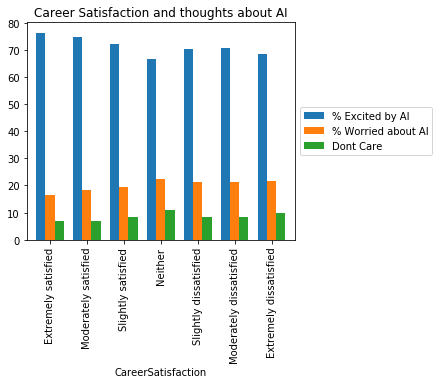

In [76]:
#Plot Career satisfaction by AI future
df_ai = clean_df[clean_df['Country'].isin(top_countries.index)]
df_ai =df_ai.groupby(['AIFuture','CareerSatisfaction'])['AIFuture'].count().unstack('CareerSatisfaction').fillna(0)
order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
df_ai=df_ai[order]
df_ai.columns = df_ai.columns.to_series().map(dict_car_sat)
df_ai = df_ai.T
df_ai['% Excited by AI'] = df_ai['Excited']*100/(df_ai['Excited']+df_ai['Worried']+df_ai['DontCare'])
df_ai['% Worried about AI'] = df_ai['Worried']*100/(df_ai['Excited']+df_ai['Worried']+df_ai['DontCare'])
df_ai['Dont Care'] = 100 - df_ai['% Excited by AI'] - df_ai['% Worried about AI'] 
fig = df_ai.drop(['DontCare','Excited','Worried'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Career Satisfaction and thoughts about AI');

In [77]:
pd.DataFrame(df_ai['% Excited by AI'])

,% Excited by AI
CareerSatisfaction,
Extremely satisfied,76.376317
Moderately satisfied,74.764187
Slightly satisfied,72.000728
Neither,66.666667
Slightly dissatisfied,70.265079
Moderately dissatisfied,70.624360
Extremely dissatisfied,68.414482


<div class="span5 alert alert-success">
As career satisfaction decreases, excitement about AI's future also decreases. Those who are indifferent about their career satisfaction are least excited by  AI.

<font size="3"><b>Calling out unethical code </b>

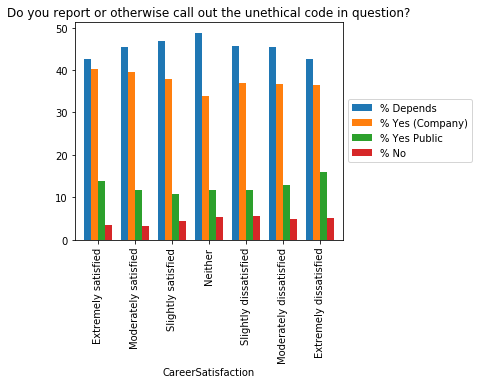

In [78]:
df_ethr =clean_df.groupby(['EthicsReport','CareerSatisfaction'])['EthicsReport'].count().unstack('CareerSatisfaction').fillna(0)
df_ethr=df_ethr[order]
df_ethr.rename(index=dict_car_sat,inplace=True)
df_ethr_t=df_ethr.T
df_ethr_t['Total']=df_ethr_t[['Depends on what it is', 'Yes, but only within the company','Yes, and publicly', 'No']].sum(axis=1)
df_ethr_t['% Depends'] = df_ethr_t['Depends on what it is']*100/df_ethr_t['Total']
df_ethr_t['% Yes (Company)']=df_ethr_t['Yes, but only within the company']*100/df_ethr_t['Total']
df_ethr_t['% Yes Public']=df_ethr_t['Yes, and publicly']*100/df_ethr_t['Total']
df_ethr_t['% No']=df_ethr_t['No']*100/df_ethr_t['Total']
df_ethr_t.rename(index=dict_car_sat,inplace=True)
fig = df_ethr_t.drop(['Yes, and publicly','Yes, but only within the company','Depends on what it is', "No",'Total'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Do you report or otherwise call out the unethical code in question?');
#error bars - z test or t test**

<div class="span5 alert alert-success">
People who are either extremely satisfied or dissatisfied are more likely to publicly call out nethical code. But people who are more satisfied tend to call out unethical code within their company.  

<font size="3"><b>Considering Ethics at work</b>

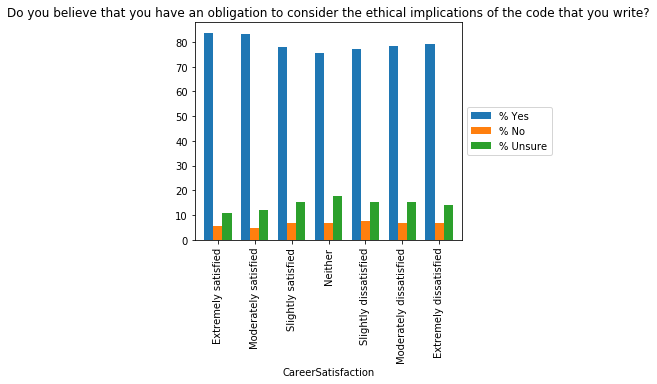

In [79]:
df_eth =clean_df.groupby(['EthicalImplications','CareerSatisfaction'])['EthicalImplications'].count().unstack('CareerSatisfaction').fillna(0)
df_eth=df_eth[order]
df_eth_t=df_eth.T
df_eth_t['Total']=df_eth_t[['Yes',"Unsure / I don't know",'No']].sum(axis=1)
df_eth_t['% Yes']=df_eth_t['Yes']*100/df_eth_t['Total']
df_eth_t['% No']=df_eth_t['No']*100/df_eth_t['Total']
df_eth_t['% Unsure'] = 100-df_eth_t['% No']-df_eth_t['% Yes']
df_eth_t.rename(index=dict_car_sat,inplace=True)
fig = df_eth_t.drop(['Yes', "Unsure / I don't know", 'No','Total'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Do you believe that you have an obligation to consider the ethical implications of the code that you write?');

<div class="span5 alert alert-success">
People who are more satisfied  with their career tend to consider ethical implications of their code more than those who aren't.

<font size="3"><b>Wake time</b>

In [80]:
#Wake time correlation with career satisfaction
df_wt =clean_df.groupby(['WakeTime','CareerSatisfaction'])['WakeTime'].count().unstack('CareerSatisfaction').fillna(0)
df_wt=df_wt[order]
df_wt = df_wt.iloc[4:10,:]
df_wt_t=df_wt.T
df_wt_t['Total']=df_wt_t.sum(axis=1)
df_wt_t.iloc[:,0]=df_wt_t.iloc[:,0]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,1]=df_wt_t.iloc[:,1]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,2]=df_wt_t.iloc[:,2]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,3]=df_wt_t.iloc[:,3]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,4]=df_wt_t.iloc[:,4]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,5]=df_wt_t.iloc[:,5]*100/df_wt_t.iloc[:,6]

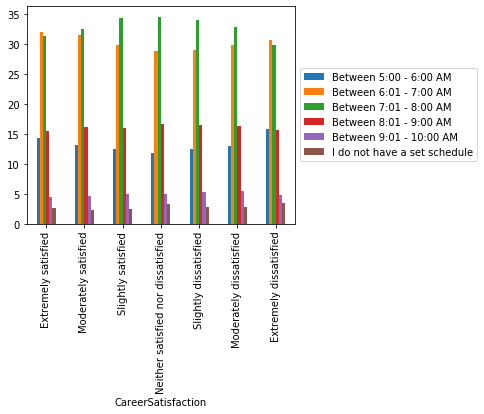

In [81]:
fig = df_wt_t.iloc[:,:6].plot(kind='bar');
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<div class="span5 alert alert-success">
Most developers wake up vetween 5-7 am. Developers who wake up earlier (5-6 am) are more likely to either be really satisfied or really dissatisfied with their careers. 

<font size="3"><b>Developer Type</b>

In [82]:
%time
dev_type = pd.DataFrame(clean_df['DevType'].str.split(';'))
dev_type.columns=['DeveloperType']
devtype_df = pd.concat([clean_df,dev_type],axis=1)
x=0
single_devtype=[]
devtype_df=devtype_df.reset_index()
for i in range(len(devtype_df)):
    if len(devtype_df['DeveloperType'][i]) == 1:
        single_devtype.append(devtype_df.loc[i])

Wall time: 0 ns


In [83]:
single_devtype = pd.DataFrame(single_devtype)
single_devtype_cs = single_devtype[['DeveloperType', 'CareerSatisfaction']]
single_devtype_cs['DevType']=single_devtype_cs['DeveloperType'].apply(', '.join)
single_devtype_cs=single_devtype_cs.groupby(['DevType', 'CareerSatisfaction'])['DevType'].count().unstack('CareerSatisfaction')

In [84]:
single_devtype_cs['Total'] = single_devtype_cs[['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
single_devtype_cs=single_devtype_cs[single_devtype_cs['Total']>100]
single_devtype_cs['Satisfied']=single_devtype_cs[['Extremely satisfied','Moderately satisfied','Slightly satisfied']].sum(axis=1)
single_devtype_cs['Neutral']=single_devtype_cs[['Neither satisfied nor dissatisfied']].sum(axis=1)
single_devtype_cs['Dissatisfied']=single_devtype_cs[['Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
single_devtype_cs['% Satisfied'] =  single_devtype_cs['Satisfied']*100/single_devtype_cs['Total']  
single_devtype_cs['% Neutral'] =single_devtype_cs['Neutral']*100/single_devtype_cs['Total']  
single_devtype_cs['% Dissatisfied'] =  single_devtype_cs['Dissatisfied']*100/single_devtype_cs['Total'] 
single_devtype_cs.sort_values('% Satisfied');

In [85]:
single_devtype_cs.index

Index(['Back-end developer', 'C-suite executive (CEO, CTO, etc.)',
       'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Desktop or enterprise applications developer', 'DevOps specialist',
       'Embedded applications or devices developer', 'Engineering manager',
       'Front-end developer', 'Full-stack developer', 'Mobile developer',
       'QA or test developer', 'System administrator'],
      dtype='object', name='DevType')

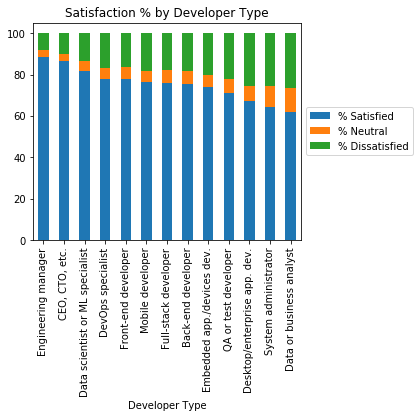

In [86]:
#Shorten developer type to make plot look better
single_devtype_cs.index=(['Back-end developer', 'CEO, CTO, etc.',  'Data or business analyst',       'Data scientist or ML specialist',       'Desktop/enterprise app. dev.', 'DevOps specialist',       'Embedded app./devices dev.', 'Engineering manager', 'Front-end developer', 'Full-stack developer', 'Mobile developer', 'QA or test developer', 'System administrator'])
fig = single_devtype_cs[['% Satisfied','% Neutral', '% Dissatisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar', stacked=True) ;
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Satisfaction % by Developer Type');plt.xlabel('Developer Type');

In [87]:
single_devtype_cs[['% Satisfied','% Neutral','% Dissatisfied']].sort_values('% Satisfied');single_devtype_cs[['% Satisfied','% Neutral','% Dissatisfied']].sort_values('% Satisfied').style.set_caption("Satisfaction rates by Developer Type")

CareerSatisfaction,% Satisfied,% Neutral,% Dissatisfied
Data or business analyst,61.6667,11.6667,26.6667
System administrator,64.3312,10.1911,25.4777
Desktop/enterprise app. dev.,67.2727,7.09091,25.6364
QA or test developer,71.2991,6.34441,22.3565
Embedded app./devices dev.,73.9224,6.03448,20.0431
Back-end developer,75.304,6.18752,18.5085
Full-stack developer,76.1251,5.84523,18.0296
Mobile developer,76.4215,5.11215,18.4664
Front-end developer,77.7699,5.64573,16.5843
DevOps specialist,77.9116,5.22088,16.8675


<div class="span5 alert alert-success">
Among non-managerial roles, data scientist or ML specialists are the most satisfied with their jobs whereas data/business analysts are the least satisfied. This is interesting because to many people, they're very similar jobs, but 

<font size="5"><a id='MachineLearning'></a> <b>Machine Learning (In Progress)</b>

In [88]:
#Normalizing variables to use in ML Algorithms
val0 = df_total.values #returns a numpy array
min_max_scaler0 = preprocessing.MinMaxScaler()
x_scaled0 = min_max_scaler0.fit_transform(val0)
df_total_norm0 = pd.DataFrame(x_scaled0)
X0 = df_total_norm0.iloc[:,:-1]
y0 = df_total_norm0.iloc[:,-1:]

In [89]:
df_total.head()

,CompanySize_n,YearsCoding_n,HoursOutside_n,Exercise_n,AIFuture_n,WakeTime_n,Hobby_Yes,OpenSource_Yes,EthicalImplications_n,EthicsReport_n,CareerSatisfaction_n
0,10000,30,0.75,6.0,1,530,1,0,3,0,3
1,15,7,1.50,3.5,1,630,1,1,3,1,0
3,300,10,0.25,1.5,-1,630,0,0,3,2,-1
4,15,16,0.75,6.0,1,430,1,0,3,2,2
5,1250,16,1.50,0.0,1,730,1,0,2,1,1


In [90]:
X0.head()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,0.117647,1.000000,1.0,0.431357,1.0,0.0,1.0,0.333333
1,0.001001,0.206897,0.294118,0.583333,1.0,0.512591,1.0,1.0,1.0,0.666667
2,0.029515,0.310345,0.000000,0.250000,0.0,0.512591,0.0,0.0,1.0,1.000000
3,0.001001,0.517241,0.117647,1.000000,1.0,0.350122,1.0,0.0,1.0,1.000000
4,0.124562,0.517241,0.294118,0.000000,1.0,0.593826,1.0,0.0,0.5,0.666667


In [91]:
###########################      VARIABLE DEFINITIONS         #################################
#x0 = CompanySize_n,YearsCoding_n,HoursOutside_n,Exercise_n,AIFuture_n,WakeTime_n,Hobby_Yes,OpenSource_Yes,EthicalImplications_n,EthicsReport_n
#y0 = CareerSatisfaction_n

In [92]:
#One hot encoding country values 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#https://github.com/codebasics/py/blob/master/ML/5_one_hot_encoding/one_hot_encoding.ipynb
le = LabelEncoder()
df_countries_salary = df[['Country','ConvertedSalary']]
df_countries_salary.Country = le.fit_transform(df_countries_salary.Country)
X_ohe = df_countries_salary[['Country']].values
y_ohe = df_countries_salary[['ConvertedSalary']]
ohe = OneHotEncoder(categorical_features=[0])
X_ohe = ohe.fit_transform(X_ohe).toarray()

In [93]:
pd.DataFrame(x_scaled0).head();

<div class="span5 alert alert-success">
Linear Regression for career satisfaction

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X0,y0,test_size=0.2,random_state=42)
#sklearn.feature_selection.chi2(X0, y0)
reg = LinearRegression().fit(X_train, y_train)
accuracy = reg.score(X_test,reg.predict(X_test))
prediction = reg.predict(X_test)
print('Linear Regression Score: '+ str(reg.score(X_test,y_test)))
print('Linear Regression Score: '+str(accuracy)) 
#rms = mean_squared_error(X_test,reg.predict(X_test))
#print('Linear Regression RMS: '+str(np.sqrt(rms)))

Linear Regression Score: 0.009162137393863179
Linear Regression Score: 1.0


In [95]:
prediction.shape

(9789, 1)

In [96]:
prediction.min()

0.5667832941060469

In [97]:
y_test.shape

(9789, 1)

In [98]:
y_test.min()

10    0.0
dtype: float64

In [99]:
################# LOGISTIC REGRESSION for career satisfaction #################
dflr = df_total.copy()
dflr['CareerSatisfaction_n'].replace([3,0,-1,2,1,-2,-3] ,[1,0,0,0,0,0,0] ,inplace=True) 
val0lr = dflr.values #returns a numpy array
min_max_scaler0 = preprocessing.MinMaxScaler()
x_scaled0lr = min_max_scaler0.fit_transform(val0lr)
dflr_norm0 = pd.DataFrame(x_scaled0lr)
X0lr = dflr_norm0.iloc[:,:-1]
y0lr = dflr_norm0.iloc[:,-1:]

X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X0lr,y0lr,test_size=0.01,random_state=42)
#tune parameters (C)***
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_trainlr, y_trainlr)
prediction = logreg.predict(X_test)
accuracy = logreg.score(X_testlr,y_testlr)
print('Logistic Regression Score:'+str(accuracy)) 

Logistic Regression Score:0.7755102040816326


In [100]:
y_testlr

,10
13876,0.0
5466,1.0
5854,0.0
12628,0.0
5822,1.0
...,...
28722,0.0
42342,1.0
40006,0.0
48684,1.0


In [101]:
pd.DataFrame(prediction).head(35)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [102]:
################# LOGISTIC REGRESSION for career dissatisfaction #################
#Career dissatisfaction variables
dflrd = df_total.copy()
dflrd['CareerSatisfaction_n'].replace([3,0,-1,2,1,-2,-3] ,[0,0,0,0,0,0,1] ,inplace=True) 
val = dflrd.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(val)
dflrd_norm0 = pd.DataFrame(x_scaled)
Xd = dflrd_norm0.iloc[:,:-1]
yd = dflrd_norm0.iloc[:,-1:]


X_traind, X_testd, y_traind, y_testd = train_test_split(Xd,yd,test_size=0.2,random_state=42)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_traind, y_traind)
accuracy = logreg.score(X_testd,logreg.predict(X_testd))
print('Logistic Regression Score:'+str(accuracy)) 

Logistic Regression Score:1.0


In [103]:
y0;

In [104]:
yd;

In [105]:
################# FEATURE SELECTION Dissatisfaction #################
features = sklearn.feature_selection.f_regression(X_traind, y_traind, center=True)
featuresdfd = pd.DataFrame(features[0]) #F value, higher the better
featuresdfd.index =df_no_dev.columns
featuresdfd.sort_values(by=0,ascending=False)#Most influential features

,0
HoursOutside_n,10.136137
WakeTime_n,9.917759
AIFuture_n,9.304626
EthicsReport_n,6.537795
EthicalImplications_n,5.009310
Hobby_Yes,2.597710
OpenSource_Yes,2.447647
CompanySize_n,1.673017
YearsCoding_n,1.423983
Exercise_n,0.367267


<div class="span5 alert alert-success">
Most important features contributing to dissatisfaction: <br>
1. HoursOutside <br>
2. WakeTime<br>
3. AIFuture <br>
4. EthicsReport <br>
5. EthicalImplications  

In [106]:
################# FEATURE SELECTION Satisfaction #################
features = sklearn.feature_selection.f_regression(X_train, y_train, center=True)
featuresdf = pd.DataFrame(features[0]) #F value, higher the better
featuresdf.index =df_no_dev.columns
featuresdf.sort_values(by=0,ascending=False)#Most influential features

,0
EthicalImplications_n,141.165859
OpenSource_Yes,141.028034
Hobby_Yes,104.815413
AIFuture_n,97.094544
EthicsReport_n,49.254106
Exercise_n,20.365530
CompanySize_n,13.105429
HoursOutside_n,9.303728
WakeTime_n,1.143772
YearsCoding_n,0.023404


<div class="span5 alert alert-success">
Most important features contributing to satisfaction: <br>
1. Ethical Implications <br>
2. Open Source<br>
3. Hobby <br>
4. AIFuture <br>
5. EthicsReport 
  

In [107]:
import scipy
print(scipy.__version__)
rp.crosstab(clean_df['Country'], clean_df['CareerSatisfaction'], prop= None, test= "chi-square", margins= True, correction = None, exact = False, expected_freqs= False)

1.3.1


(                                         CareerSatisfaction  \
                                      Extremely dissatisfied   
 Country                                                       
 Afghanistan                                               2   
 Albania                                                   1   
 Algeria                                                   2   
 Andorra                                                   0   
 Argentina                                                10   
 ...                                                     ...   
 Venezuela, Bolivarian Republic of...                      4   
 Viet Nam                                                  5   
 Yemen                                                     0   
 Zimbabwe                                                  0   
 All                                                    1350   
 
                                                           \
                                      Ext

In [108]:
rp.crosstab(clean_df['Exercise'], clean_df['CareerSatisfaction'], prop= None, test= "chi-square", margins= True, correction = None, exact = False, expected_freqs= False)

(                               CareerSatisfaction                      \
                            Extremely dissatisfied Extremely satisfied   
 Exercise                                                                
 1 - 2 times per week                          358                2678   
 3 - 4 times per week                          260                2039   
 Daily or almost every day                     183                1384   
 I don't typically exercise                    549                3300   
 All                                          1350                9401   
 
                                                                          \
                            Moderately dissatisfied Moderately satisfied   
 Exercise                                                                  
 1 - 2 times per week                           910                 5674   
 3 - 4 times per week                           626                 4024   
 Daily or almost every day

 0  Pearson Chi-square ( 18.0) =   171.1145
 1                     p-value =     0.0000
 2                  Cramer's V =     0.0341)

In [109]:
'''features = df_total.iloc[:,:-1] #
clf = MultinomialNB()
clf.fit(X_train, y_train)
x = np.eye(X_test.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)''';
'''good_features = features[ind[:5]]
bad_features = features[ind[-5:]]
good_prob = probs[ind[:5]]
bad_prob = probs[ind[-5:]]''';

In [110]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression
#https://scikit-learn.org/stable/modules/feature_selection.html
#from sklearn.feature_selection import SelectKBest, chi2;
#X_new = SelectKBest(chi2, k=4).fit_transform(X0, y0)

In [111]:
################# SGDREGRESSOR ################# 
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
y_train=np.ravel(y_train)
clf.fit(X_train, y_train)
rms = mean_squared_error(y_test, clf.predict(X_test))
prediction = clf.predict(X_test)
print('SGDRegressor Score: '+ str(clf.score(X_test,prediction)))
print('SGDRegressor RMS: '+str(np.sqrt(rms)))

SGDRegressor Score: 1.0
SGDRegressor RMS: 0.26637526036790493


In [112]:
################# RANDOM FOREST REGRESSOR ################# 
#https://github.com/NathanEpstein/pydata-london
model = RandomForestRegressor()
model = model.fit(X_train, y_train)
#rms = mean_squared_error(X_test, model.predict(X_test))
##BEST
prediction = model.predict(X_test)
#print('Random Forest score: '+str(model.score(y_test,prediction))) ???
print('Random Forest RMS: '+str(rms))

Random Forest RMS: 0.07095577933606914


In [113]:
####### RANDOM FOREST REGRESSOR important features #########
importances = model.feature_importances_
X_columns = df_total.iloc[:,:-1].columns
list(zip(X_columns, model.feature_importances_))

[('CompanySize_n', 0.19335362089955788),
 ('YearsCoding_n', 0.21336909017401662),
 ('HoursOutside_n', 0.11319734057814441),
 ('Exercise_n', 0.111596715184508),
 ('AIFuture_n', 0.030498158537661003),
 ('WakeTime_n', 0.16832222175297257),
 ('Hobby_Yes', 0.03153838694663872),
 ('OpenSource_Yes', 0.007104193729808682),
 ('EthicalImplications_n', 0.020671832861886667),
 ('EthicsReport_n', 0.11034843933480543)]

In [114]:
################# RANDOM FOREST CLASSIFIER #################  
y0_job =df[['CareerSatisfaction_n']]
y0_job=np.ravel(y0_job)
#change number of trees?
X_train, X_test, y_train, y_test = train_test_split(X0,y0_job,test_size=0.2,random_state=42)
model = RandomForestClassifier()
model = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print('Random Forest model score is: '+str(model.score(X_test,y_test))) #???
#print('Random Forest model RMS is: '+str(model.score(X_test,y_test)))

Random Forest model score is: 0.2712228011032792


In [115]:
importances = model.feature_importances_
importances

array([0.19337202, 0.21023102, 0.12738865, 0.10232222, 0.0345675 ,
       0.19645942, 0.02587212, 0.01018944, 0.01755197, 0.08204562])

In [116]:
################ Ridge #################
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)
reg.alpha_ #gives value of 10
score = reg.score(X_test, y_test) #suspicious of scores??
#Maybe bad model
print('Ridge regression model score is: '+str(score)) #R^2

Ridge regression model score is: 0.009236334955706083


In [117]:
############################### KNN model #######################################
#y0_job =conc1[['JobSatisfaction']]
#y0_job=np.ravel(y0_job)
X_train, X_test, y_train, y_test = train_test_split(X0,y0_job,test_size=0.2,random_state=42)
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
#Tune neighbors
#print(prediction[0:10]) #y_test.head(10)
#print('KNN score: '+str(knn.score(y_test, prediction)))???
#rms = mean_squared_error(X_test,y_test)
#print('KNN RMS: '+str(np.sqrt(rms)))
knn.score(X_test,y_test)

0.28378792522218815

In [118]:
pd.DataFrame([y_test, reg.predict(X_test)])

,0,1,2,3,4,5,6,7,8,9,...,9779,9780,9781,9782,9783,9784,9785,9786,9787,9788
0,2.000000,3.000000,2.000000,1.00000,3.000000,-2.000000,1.000000,3.000000,2.000000,3.000000,...,1.000000,3.000000,1.000000,2.000000,1.000000,2.000000,3.000000,0.000000,3.00000,2.000000
1,1.372552,1.432366,1.221441,1.33277,1.361773,1.253241,1.328182,1.186954,1.088747,1.389502,...,1.334579,1.259739,0.829014,1.219402,1.122866,1.419392,1.235171,1.165978,0.66166,1.325995


In [119]:
################ Lasso #################
X_train, X_test, y_train, y_test = train_test_split(X0,y0,test_size=0.2,random_state=42)
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print('Lasso score: '+str(lasso.score(X_test, y_test))) #R^2
rms = mean_squared_error(y_test, lasso.predict(X_test))
print('RMS: '+str(np.sqrt(rms))) #not much rms difference b/w this and linear regression
#-ve but really close to 0 means good https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#########Look up lasso plot file:///Users/alphajaiswal/Google%20Drive/1Courses/4%20Springboard/DataCamp/Supervised%20Learning/chapter2.pdf
#lasso.score(X_test,y_test)

Lasso score: -2.4150082166940482e-05
RMS: 0.26718748944312815


In [120]:
#Linear Regression with DevType added
#X0_dev =pd.concat([X0,dev_type_num],axis=1)# X0.join(dev_type_num)#
#X0_dev.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(dev_type_num,y0,test_size=0.2,random_state=42)
################# LINEAR REGRESSION with DevType#################
reg = LinearRegression().fit(X_train, y_train)
accuracy = reg.score(X_train, reg.predict(X_train))
#print(accuracy*100,'%')
#conc1['AIFuture'].unique()
rms = mean_squared_error(y_test, reg.predict(X_test))
print('Linear Regression RMS: '+str(np.sqrt(rms)))
print('Linear Regression accuracy: '+str(accuracy))

Linear Regression RMS: 0.2668955976748441
Linear Regression accuracy: 1.0


In [121]:
#*** gradient boosting regressor
#*** cross validate training data

In [122]:
#iterate through the dataframe with devtypes row of the riginal DF
'''conc2 = conc1['DevType'].str.split(';')
conc2.rename('NewDevType',inplace=True)
conc3=pd.concat([conc1,conc2],axis=1)
conc3=conc3.drop('DevType',axis=1)
conc3
conc4=conc3[['EducationTypes','NewDevType']] 
############### Only Devtype dummified ############### dev_type_num
dev_type_num=pd.DataFrame(mlb.fit_transform(conc4['NewDevType']),columns=mlb.classes_, index=conc4.index)#.head()
conc6=conc3.drop('NewDevType',axis=1) ############### it has all columns except dev type ################
dev_type_num.head()
trialdf = pd.concat([conc6[['CareerSatisf','Yrs_num']],dev_type_num],axis=1)
########### NORMALIZE ##############
val = trialdf.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(val)
trialdf_norm = pd.DataFrame(x_scaled)
X = trialdf_norm.iloc[:,1:]
y = trialdf_norm.iloc[:,0:1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
accuracy = reg.score(X_test,y_test)
rms = mean_squared_error(y_test, reg.predict(X_test))
np.sqrt(rms)''';